## Section 0. Load modules and data

In [2]:
# load modules and data
import inspect
from rich.console import Console
from rich.syntax import Syntax
from pqdm.processes import pqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from tqdm import tqdm
from whygreedy import *
from pprint import pprint
import pandas as pd

# set up plotting env
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({'font.size': 14})
console = Console(width=120)

In [ ]:

# preloaded pairs
# a `pair` is a tuple of (reactant, product list) # each pair correspond to a reaction
mp_oxidation_pairs = pkl_load("calculate/mp_oxidation_pairs.pkl")
mp_decomposition_pairs = pkl_load("calculate/mp_decomp_pairs.pkl")

# precomputed data for oxidation
mp_oxidation_records_lazy = pkl_load("calculate/mp_oxidation_records_lazy.pkl")
mp_oxidation_records_diligent = pkl_load("calculate/mp_oxidation_records_diligent.pkl")
mp_oxidation_records_lp = pkl_load("calculate/mp_oxidation_records_lp.pkl")

# precomputed data for decomposition
mp_decomp_records_lazy = pkl_load("calculate/mp_decomp_records_lazy.pkl")
mp_decomp_records_diligent = pkl_load("calculate/mp_decomp_records_diligent.pkl")
mp_decomp_records_lp = pkl_load("calculate/mp_decomp_records_lp.pkl")
mp_decomp_records_pmghull = pkl_load("calculate/mp_pmgehull_records.pkl")

In [7]:

for records in [mp_oxidation_records_lazy,mp_oxidation_records_diligent]:#,,mp_oxidation_records_lp,mp_decomp_records_lazy,mp_decomp_records_diligent,mp_decomp_records_lp, mp_decomp_records_pmghull]:
# for records in [mp_oxidation_records_lazy,mp_oxidation_records_diligent,mp_oxidation_records_lp,mp_decomp_records_lazy,mp_decomp_records_diligent,mp_decomp_records_lp, mp_decomp_records_pmghull]:
#     print(records[0])
    for r in records:
        if not isinstance(r, dict):
            print(r)
    # assert all(isinstance(r, dict) for r in records)  # check errors


float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float divis

A record is a dictionary contains precalculated results. For example:
```
{'dh_diligent': -0.9155174025000004,  # \Delta H from diligent greedy
 'dh_exact': -0.9155174025000004,  # \Deleta H from linear optimization
 'dh_old': -0.9155174025000004,  # \Delta H from Twyman et al., lazy greedy
 'original': {'Br': 0.5, 'Cl': 0.5},  # reactant
 'oxides': [{'Br': 0.4, 'O': 0.6},
            {'Br': 0.6666666666666666, 'O': 0.3333333333333333},
            {'Cl': 0.3333333333333333, 'O': 0.6666666666666666},
            {'Cl': 0.2222222222222222, 'O': 0.7777777777777778},
            {'Cl': 0.25, 'O': 0.75},
            {'Cl': 0.6666666666666666, 'O': 0.3333333333333333}],  # a list of products
 'sol_diligent': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0],  # x_i solved by diligent greedy
 'sol_exact': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0],  # x_i solved by linear optimization
 'sol_old': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0]},  # x_i solved by Twyman et al., lazy greedy
```

In [3]:
r = mp_oxidation_records[0]
pprint(r)

{'dh_diligent': -0.9155174025000004,
 'dh_exact': -0.9155174025000004,
 'dh_old': -0.9155174025000004,
 'original': {'Br': 0.5, 'Cl': 0.5},
 'oxides': [{'Br': 0.4, 'O': 0.6},
            {'Br': 0.6666666666666666, 'O': 0.3333333333333333},
            {'Cl': 0.3333333333333333, 'O': 0.6666666666666666},
            {'Cl': 0.2222222222222222, 'O': 0.7777777777777778},
            {'Cl': 0.25, 'O': 0.75},
            {'Cl': 0.6666666666666666, 'O': 0.3333333333333333}],
 'sol_diligent': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0],
 'sol_exact': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0],
 'sol_old': [1.25, 0.0, 0.0, 2.25, 0.0, 0.0]}


There are two reactions in `mp_decomposition_pairs` have empty product list (mentioned in II.C in the main text), so we have no iterations in greedy methods and dh values are calculated as the initial value `inf`. we will set them to zero.

In [4]:
for i, (c, cps) in enumerate(mp_decomposition_pairs):
    if len(cps) == 0:
        print("="*6)
        print(c, c.mpid, cps)
        print("dh_old calculated as", mp_decomposition_records[i]["dh_old"], "set to 0")
        mp_decomposition_records[i]["dh_old"] = 0.0
        print("dh_diligent calculated as", mp_decomposition_records[i]["dh_diligent"], "set to 0")
        mp_decomposition_records[i]["dh_diligent"] = 0.0

{'Pt': 1.0} mp-126 []
dh_old calculated as inf set to 0
dh_diligent calculated as inf set to 0
{'Ne': 1.0} mp-111 []
dh_old calculated as inf set to 0
dh_diligent calculated as inf set to 0


In [5]:
# lookup tables for ehull and compound
mpid_to_compound = dict()
for c, _ in mp_decomposition_pairs:
    mpid_to_compound[c.mpid] = c

mpid_to_ehull = dict()
for d in json_load("data/mp.json.gz"):
    mpid = d["task_id"]
    ehull = d["e_above_hull"]
    mpid_to_ehull[mpid] = ehull

mpid_to_recal_ehull = {r["c_id"]:r["pmg_ehull"] for r in mp_ehull_records}

## Section 1. Lazy and diligent greedy
In this section we will explore different implementations of the greedy algorithm from [Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644). These implementations can be found at `whygreedy.algo`.


### 1.1 Implementations
We start with the ranking parameter definition.

In [2]:
# printout source with python syntax
syntax = Syntax(inspect.getsource(calculate_ranking_parameter), "python")
console.print(syntax)

def calculate_ranking_parameter(oxide: Compound, original: Compound, for_oxide=True) -> float:                          
    """                                                                                                                 
    this is the ranking parameter as defined in the paper, a smaller number indicated the oxide is more favored,        
    the one with the smallest ranking parameter will be used to "consume" the original compound                         
    """                                                                                                                 
    # if the oxide has an element with > 0 composition,                                                                 
    # and this element is not present or is of 0 composition in the                                                     
    # original compound,                                                                                                
    # then the ranking parameter is inf because it is impossible to consume the original compound                       
    # with this oxide (and the solution for this oxide is 0)                                                            
    if for_oxide:                                                                                                       
        for e in oxide.elements_exclude_oxygen:                                                                         
            oxide_composition = oxide.normalized_formula[e]                                                             
            original_composition = original.normalized_formula[e]                                                       
            if not is_close_to_zero(oxide_composition) and is_close_to_zero(original_composition):                      
                return np.inf                                                                                           
        p = 0                                                                                                           
        for element in oxide.elements:                                                                                  
            if element == "O":                                                                                          
                continue                                                                                                
            c = oxide.normalized_formula[element] / original.normalized_formula[element]                                
            p += c                                                                                                      
        rp = oxide.formation_energy_per_atom / p                                                                        
        return rp                                                                                                       
    else:                                                                                                               
        for e in oxide.elements:                                                                                        
            oxide_composition = oxide.normalized_formula[e]                                                             
            original_composition = original.normalized_formula[e]                                                       
            if not is_close_to_zero(oxide_composition) and is_close_to_zero(original_composition):                      
                return np.inf                                                                                           
        p = 0                                                                                                           
        for element in oxide.elements:                                                                                  
            c = oxide.normalized_formula[element] / original.normalized_formula[element]                                
       

Now we implement the greedy algorithm by ourselves. We will use an argument `diligent_greedy` to switch between lazy and diligent versions.

In [3]:
syntax = Syntax(inspect.getsource(find_greedy), "python")
console.print(syntax)

def find_greedy(                                                                                                        
        oxides: list[Compound], original: Compound, first_choice: int = 0, diligent_greedy=True, for_oxide=True,        
) -> Tuple[list[float], float]:                                                                                         
    # placeholder for the solution                                                                                      
    solution = []                                                                                                       
    final_enthalpy = 0.0                                                                                                
                                                                                                                        
    # assign an index for oxides                                                                                        
    for ioxi, oxi in enumerate(oxides):                                                                                 
        oxi.properties["index"] = ioxi                                                                                  
                                                                                                                        
    # we will be updating the original compound, better make a deep copy                                                
    updated_original = deepcopy(original)                                                                               
    sorted_oxides = oxides  # no need for deep copy                                                                     
                                                                                                                        
    # init the loop and perform the first greedy ranking                                                                
    counter = 0                                                                                                         
    sorted_oxides = sorted(sorted_oxides,                                                                               
                           key=lambda x: calculate_ranking_parameter(x, updated_original, for_oxide=for_oxide))         
                                                                                                                        
    while len(solution) < len(oxides):                                                                                  
        if diligent_greedy:                                                                                             
            # greedy means to find the best in each iteration                                                           
            # the implementation found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) does not sort the    
            # oxide list at every iteration (only at initialization), so it is not a greedy algorithm                   
            # this becomes even more problematic considering they used different `first_choice`                         
            sorted_oxides = sorted(sorted_oxides,                                                                       
                                   key=lambda x: calculate_ranking_parameter(x, updated_original, for_oxide=for_oxide)) 
        # we can force the first choice to be something else, but always choose the best starting the 2nd iteration     
        if counter == 0:                                                                                                
            favored_oxide = sorted_oxides[first_choice]                                                                 
            index_to_pop = first_choice                                                                                 
        else:                                                                                                           
       

Finally, we have the implementation we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg). We wrote a wrapper `find_greedy_old` such that it works with our schema.

In [4]:
syntax = Syntax(inspect.getsource(find_greedy_old), "python")
console.print(syntax)

def find_greedy_old(oxides: list[Compound], original: Compound, first_choice: int = 0, for_oxides=True) -> Tuple[       
    list[float], float]:                                                                                                
    """                                                                                                                 
    This is just a wrapper for the implementation from 10.1021/acs.chemmater.1c02644                                    
    It is identical to `find_greedy` with `diligent_greedy` set to False                                                
    """                                                                                                                 
    stable_oxides = []                                                                                                  
    for ioxide, oxide in enumerate(oxides):                                                                             
        stable_oxide = {                                                                                                
            "nsites": 1,                                                                                                
            # have to make a copy as `find_comp` changes it                                                             
            "unit_cell_formula": {k: v for k, v in oxide.normalized_formula.items()},                                   
            "formation_energy_per_atom": oxide.formation_energy_per_atom,                                               
            "index": ioxide,                                                                                            
            "elements": oxide.elements,                                                                                 
        }                                                                                                               
        stable_oxides.append(stable_oxide)                                                                              
    compound_unit_cell = original.normalized_formula                                                                    
                                                                                                                        
    if for_oxides:                                                                                                      
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_oxides, compound_unit_cell,         
                                                                             original.formation_energy_per_atom,        
                                                                             "Oxide", first_choice)                     
    else:                                                                                                               
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_oxides, compound_unit_cell,         
                                                                             original.formation_energy_per_atom, "non", 
                                                                             first_choice)                              
                                                                                                                        
    solution = np.zeros(len(oxides))                                                                                    
    for oxide in solution_oxides:                                                                                       
        solution[oxide["index"]] = oxide["ratio"]                                                                       
    return solution.tolist(), delta_enthalpy                                                                            
                                                                                                      

Now we have three different implementations:
- `find_greedy_old` is the one by Twyman et al. we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg).
- `find_greedy(diligent=False)` is the *lazy* greedy algorithm
- `find_greedy(diligent=True)` is the *diligent* greedy algorithm

### 1.2 Lazy vs diligent: random oxidation reactions
We start with randomly generated oxidation reactions.

In [5]:
# function to calculate data to compare old, lazy and diligent
syntax = Syntax(inspect.getsource(calculate_diligent_vs_lazy_oxides), "python")
console.print(syntax)

def calculate_diligent_vs_lazy_oxides(pair: list[Compound, list[Compound]]):                                            
    original, oxides = pair                                                                                             
                                                                                                                        
    dh_old_min = np.inf                                                                                                 
    dh_lazy_min = np.inf                                                                                                
    dh_diligent_min = np.inf                                                                                            
                                                                                                                        
    sol_old_min = None                                                                                                  
    sol_lazy_min = None                                                                                                 
    sol_diligent_min = None                                                                                             
                                                                                                                        
    for i in range(len(oxides)):                                                                                        
        sol_old, dh_old = find_greedy_old(oxides, original, first_choice=i, for_oxides=True)                            
        sol_lazy, dh_lazy = find_greedy(oxides, original, first_choice=i, diligent_greedy=False, for_oxide=True)        
        sol_diligent, dh_diligent = find_greedy(oxides, original, first_choice=i, diligent_greedy=True, for_oxide=True) 
                                                                                                                        
        # check elemental conservation                                                                                  
        assert check_solution(sol_old, oxides, original)                                                                
        assert check_solution(sol_lazy, oxides, original)                                                               
        assert check_solution(sol_diligent, oxides, original)                                                           
                                                                                                                        
        # confirm we reproduce the old implementation                                                                   
        assert is_close_to_zero(dh_lazy - dh_old) and np.allclose(sol_lazy, sol_old)                                    
                                                                                                                        
        if dh_old < dh_old_min:                                                                                         
            dh_old_min = dh_old                                                                                         
            sol_old_min = sol_old                                                                                       
        if dh_lazy < dh_lazy_min:                                                                                       
            dh_lazy_min = dh_lazy                                                                                       
            sol_lazy_min = sol_lazy                                                                                     
        if dh_diligent < dh_diligent_min:                                                                               
            dh_diligent_min = dh_diligent                                                                               
            sol_diligent_min = sol_diligent                                                                             
       

In [6]:
# this should take < 30s
seed_max = 1000
random_oxidation_pairs = [gen_random_data(["A", "B", "C", "D"], 5, seed) for seed in range(seed_max)]
records_random_diligent_vs_lazy = pqdm(random_oxidation_pairs, calculate_diligent_vs_lazy_oxides, n_jobs=8)

QUEUEING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1000 [00:00<?, ?it/s]

First confirm that `find_greedy_old` is identical to the *lazy* greedy algorithm using

In [7]:
def old_is_lazy(r:dict) -> bool:
    return is_close_to_zero(r["dh_lazy"] - r["dh_old"]) and np.allclose(r["sol_lazy"], r["sol_old"])

assert len(records_random_diligent_vs_lazy) == len(random_oxidation_pairs)
assert all(old_is_lazy(r) for r in records_random_diligent_vs_lazy)

Then take a look at the differences between lazy and diligent.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


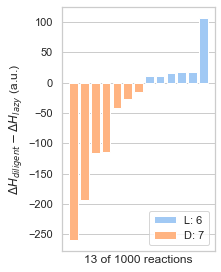

In [93]:
def nonzero_diff(records: list[dict], field1="dh_diligent", field2="dh_old"):
    diff = []
    for i, record in enumerate(records):
        dh_1 = record[field1]
        dh_2 = record[field2]
        if not is_close_to_zero(dh_1 - dh_2):
            diff.append(dh_1 - dh_2)
    return diff

def plot_diligent_vs_lazy_bar(diff, ntotal):
    fig, ax = plt.subplots(figsize=(3.3, 4))
    x_positive = []
    x_negative = []
    y_positive = []
    y_negative = []
    for x, y in zip(range(len(diff)), sorted(diff)):
        if y > 0:
            y_positive.append(y)
            x_positive.append(x)
        else:
            y_negative.append(y)
            x_negative.append(x)
    ax.bar(x_positive, y_positive, label="L: {}".format(len(y_positive)))
    ax.bar(x_negative, y_negative, label="D: {}".format(len(y_negative)))
    ax.set_xticks([])
    ax.set_xlabel("{} of {} reactions".format(len(diff), ntotal))
    ax.set_ylabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$ (a.u.)")
    ax.legend(loc="lower right")
    return fig

diff_random_diligent_vs_lazy = nonzero_diff(records_random_diligent_vs_lazy)
fig = plot_diligent_vs_lazy_bar(diff_random_diligent_vs_lazy, len(records_random_diligent_vs_lazy))
fig.tight_layout()
fig.savefig("data/float/diligent_vs_lazy_random.eps")

From randomly generated oxidation reactions it is unclear if the *diligent* version is better than the *lazy* one.
But clearly these two implementations are different.

### 1.3 Lazy vs diligent: MP reactions
How about reactions from MP dataset?

oxidation diff: min--0.7733 max-0.4891 mean--0.0926
decomposition diff: min--0.3013 max-0.1911 mean--0.0182


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


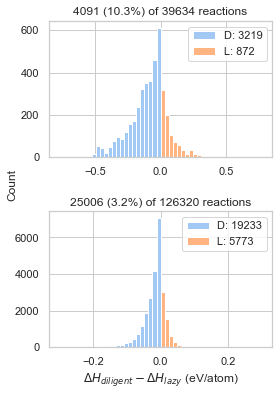

In [181]:
diff_mpox = nonzero_diff(records=mp_oxidation_records)
diff_mpdc = nonzero_diff(records=mp_decomposition_records)

print("oxidation diff: min-{:.4f} max-{:.4f} mean-{:.4f}".format(min(diff_mpox), max(diff_mpox), np.mean(diff_mpox)))
print("decomposition diff: min-{:.4f} max-{:.4f} mean-{:.4f}".format(min(diff_mpdc), max(diff_mpdc), np.mean(diff_mpdc)))

def diff_hist_data(diff, bins=50):
    lim = max([abs(max(diff)), abs(min(diff))])
    heights, bins = np.histogram(diff, bins, range=(-lim, lim))
    bin_width = np.diff(bins)[0]
    bin_pos = bins[:-1] + bin_width / 2
    mask_pos = (bin_pos > 0)
    mask_neg = (bin_pos < 0)
    return bin_pos[mask_pos], heights[mask_pos], bin_pos[mask_neg], heights[mask_neg], bin_width

fig, (ax1, ax2) = plt.subplots(figsize=(4, 6), nrows=2, ncols=1)
x1pos, y1pos, x1neg, y1neg, w1 = diff_hist_data(diff_mpox, 50)
x2pos, y2pos, x2neg, y2neg, w2 = diff_hist_data(diff_mpdc, 50)
ax1.bar(x1neg, y1neg,label="D: {}".format(int(sum(y1neg))), width=w1)
ax1.bar(x1pos, y1pos,label="L: {}".format(int(sum(y1pos))), width=w1)
ax1.legend()
ax2.bar(x2neg, y2neg,label="D: {}".format(int(sum(y2neg))), width=w2)
ax2.bar(x2pos, y2pos,label="L: {}".format(int(sum(y2pos))), width=w2)
ax2.legend()
assert sum(y1pos) + sum(y1neg) == len(diff_mpox)
assert sum(y2pos) + sum(y2neg) == len(diff_mpdc)
fig.supylabel("Count", fontsize=12, x=-0.02)
# fig.supxlabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$ (eV/atom)", fontsize=12)
# ax1.set_ylabel("Count", fontsize=12)
ax1.set_title("{} ({:.1%}) of {} reactions".format(len(diff_mpox), len(diff_mpox)/len(mp_oxidation_records), len(mp_oxidation_records)))
ax2.set_title("{} ({:.1%}) of {} reactions".format(len(diff_mpdc), len(diff_mpox)/len(mp_decomposition_records), len(mp_decomposition_records)))

# ax2.set_ylabel("Count", fontsize=12)
ax2.set_xlabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$ (eV/atom)", fontsize=12)
fig.subplots_adjust(hspace=0.4)
fig.savefig("data/float/diligent_vs_lazy_mp.eps", bbox_inches="tight")
fig.savefig("data/float/diligent_vs_lazy_mp.tiff", bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})

From MP dataset, the *diligent* version is clearly better than the *lazy* one for both oxidation and decomposition.

## Section 2. Why greedy, when you can be exact?
Recall our definition for the oxidation product problem from the main text.
This is a linear optimization (or linear programming, LP) problem.
The objective function is the sum $\Sigma_i x_i H^f_i$ where all $x_i$ are non-negative.
The feasible region of $X^s$ is constrained by elemental conservation.

### 2.1 LP implementation
There are many well-established packages for LP problems, here we use [gurobi](https://www.gurobi.com/).
`pip install gurobipy` installs `gurobi` with a limited license enough in most cases.
For large problems (some decomposition reactions in MP) you may need an [academic license](https://www.gurobi.com/academia/academic-program-and-licenses/)
The LP solver is implemented in `whygreedy.find_lp`.

In [120]:
syntax = Syntax(inspect.getsource(find_lp), "python")
console.print(syntax)

def find_lp(oxides: list[Compound], original: Compound) -> Tuple[list[float], float]:                                   
    if len(oxides) == 0:                                                                                                
        return [], - original.formation_energy_per_atom                                                                 
                                                                                                                        
    elements_in_oxides = []                                                                                             
    for oxi in oxides:                                                                                                  
        elements_in_oxides += oxi.elements                                                                              
    elements_in_oxides = set(elements_in_oxides)                                                                        
    elements_in_constraints = sorted(set(original.elements).intersection(elements_in_oxides))                           
                                                                                                                        
    # init gurobi model, suppress output                                                                                
    with gp.Env(empty=True) as env:                                                                                     
        env.setParam('OutputFlag', 0)                                                                                   
        env.setParam('LogToConsole', 0)                                                                                 
        env.start()                                                                                                     
        with gp.Model(env=env) as m:                                                                                    
                                                                                                                        
            # add variables                                                                                             
            x = []                                                                                                      
            for ioxi, oxi in enumerate(oxides):                                                                         
                x_i = m.addVar(name=str(ioxi))                                                                          
                x.append(x_i)                                                                                           
                                                                                                                        
            # add stoi constraints                                                                                      
            c = []                                                                                                      
            for e in elements_in_constraints:                                                                           
                element_sum = 0                                                                                         
                for i, x_i in enumerate(x):                                                                             
                    try:                                                                                                
                        composition = oxides[i].normalized_formula[e]                                                   
                    except KeyError:                                                                                    
                        continue                                                                                        
                    element_sum += composition * x_i                                                                    
       

### 2.2 Greedy vs LP: random oxidation reactions
Again we start with randomly generated oxidation reactions.

In [122]:
seed_max = 1000
random_oxidation_pairs = [gen_random_data(["A", "B", "C", "D"], 5, seed) for seed in range(seed_max)]
random_oxidation_records = pqdm(random_oxidation_pairs, calculate_greedy_vs_exact_oxidation, n_jobs=8)  # ~ 16 s

QUEUEING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1000 [00:00<?, ?it/s]

Lazy: max diff = 21.8311 %, mean = 2.4836
Diligent: max diff = 12.3397 %, mean = 2.1614
Do lazy and diligent always both get things wrong? False
# of cases where both laze and diligent are wrong: 92


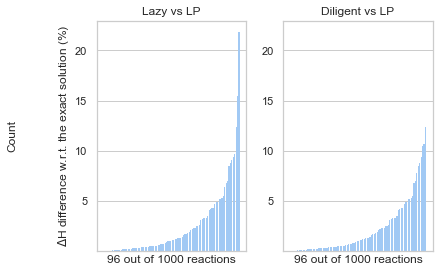

In [183]:
def plot_greedy_vs_exact_bar(records, abs_percent=False, yunit="eV/atom"):

    nonzero_diff_lazy = []
    nonzero_diff_diligent = []
    lazy_wrong = []
    diligent_wrong = []
    for i, record in enumerate(records):
        dh_lazy = record["dh_old"]
        dh_diligent = record["dh_diligent"]
        dh_exact = record["dh_exact"]
        diff_lazy = dh_exact - dh_lazy
        diff_diligent = dh_exact - dh_diligent
        # exact should never be worse
        assert diff_diligent < 1e-7
        assert diff_lazy < 1e-7

        if abs(diff_diligent) > 1e-7:
            diligent_wrong.append(i)
            if abs_percent:
                diff_diligent = abs(100 * diff_diligent/dh_exact)
            nonzero_diff_diligent.append(diff_diligent)

        if abs(diff_lazy) > 1e-7:
            lazy_wrong.append(i)
            if abs_percent:
                diff_lazy = abs(100 * diff_lazy/dh_exact)
            nonzero_diff_lazy.append(diff_lazy)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ymin = min(min(nonzero_diff_diligent), min(nonzero_diff_lazy))
    ymax = max(max(nonzero_diff_diligent), max(nonzero_diff_lazy))
    ylim = [ymin - abs(0.05*ymin), ymax + abs(0.05*ymax)]
    for name, data, ax, setylabel in zip(
        ["Lazy", "Diligent",],
        [nonzero_diff_lazy, nonzero_diff_diligent],
        [ax1, ax2],
        [True, False]
    ):
        ax.bar(range(len(data)), sorted(data), linewidth=0.01)
        if abs_percent and setylabel:
            ax.set_ylabel(r"$\Delta$H difference w.r.t. the exact solution (%)")
        elif setylabel:
            ax.set_ylabel(r"$\Delta H_{{LP}} - \Delta H_{{{}}}$ ({})".format(name, yunit))
        ax.set_title("{} vs LP".format(name))
        ax.set_xlabel("{} out of {} reactions".format(len(data), len(records)))
        ax.set_ylim(ylim)
        ax.set_xticks([])
        if abs_percent:
            print("{}: max diff = {:.4f} %, mean = {:.4f}".format(name, max(data), np.mean(data)))
        else:
            print("{}: max diff = {:.4f} {}, mean = {:.4f}".format(name, min(data), yunit, np.mean(data)))
    fig.tight_layout()
    print("Do lazy and diligent always both get things wrong?", set(lazy_wrong) == set(diligent_wrong))
    both_wrong = set(lazy_wrong).intersection(set(diligent_wrong))
    print("# of cases where both laze and diligent are wrong:", len(both_wrong))
    return fig, lazy_wrong, diligent_wrong

fig, lazy_wrong, diligent_wrong = plot_greedy_vs_exact_bar(random_oxidation_records, abs_percent=True, yunit="a.u.")
figname = "greedy_vs_lp_random"
fig.savefig("data/float/{}.eps".format(figname), bbox_inches="tight")
fig.savefig("data/float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})

Out of 1000 randomly generated oxidation reactions, in 96 of them LP finds a better solution than the lazy or diligent greedy method, and LP never finds a worse solution. The percent difference in $\Delta H$ can be as large as 21.83% for *lazy* and 12.34% for *diligent*. In 92 of the 96 cases, both lazy and diligent methods failed to find the exact solution.

### 2.2 timing
Since the greedy implementations require looping over all possible `first_choice`, it is significantly slower than the linear programming method when the # of oxides is large.

In [ ]:
original, oxides = gen_random_data(["A", "B", "C", "D"], 5, 42)
print("# of oxides:", len(oxides))
%timeit find_lp(oxides, original)
%timeit for i in range(len(oxides)) : find_greedy_old(oxides, original, first_choice=i)

100%|██████████| 9/9 [05:36<00:00, 37.37s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


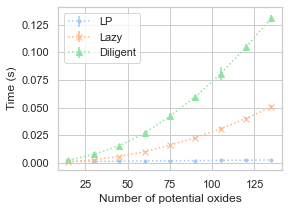

In [243]:
def timing(find_function, oxides, original):
    ts1 = time.perf_counter()
    if "greedy" in find_function.__name__:
        for i in range(len(oxides)):
            find_function(oxides, original, first_choice=i)
    else:
        find_function(oxides, original)
    ts2 = time.perf_counter()
    return ts2 - ts1

def timing_plot(num_oxides_per_chemsys = tuple(range(1, 10)), repeat=500):
    time_lp = []
    time_lp_std = []
    time_lazy = []
    time_lazy_std = []
    time_diligent = []
    time_diligent_std = []
    num_oxides = []
    for n in tqdm(num_oxides_per_chemsys):
        original, oxides = gen_random_data(["A", "B", "C", "D"], n, 42)
        timing_lazy = []
        timing_diligent = []
        timing_lp = []
        for ir in range(repeat):
            timing_lazy.append(timing(find_greedy_old, oxides, original))
            timing_diligent.append(timing(find_greedy, oxides, original))  # diligent by default
            timing_lp.append(timing(find_lp, oxides, original))
        time_lp.append(np.mean(timing_lp))
        time_lp_std.append(np.std(timing_lp))
        time_lazy.append(np.mean(timing_lazy))
        time_lazy_std.append(np.std(timing_lazy))
        time_diligent.append(np.mean(timing_diligent))
        time_diligent_std.append(np.std(timing_diligent))
        num_oxides.append(len(oxides))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.errorbar(num_oxides, time_lp, ls=":", marker=".", yerr=time_lp_std, label="LP")
    ax.errorbar(num_oxides, time_lazy, ls=":", marker="x", yerr=time_lazy_std, label="Lazy")
    ax.errorbar(num_oxides, time_diligent, ls=":", marker="^", yerr=time_diligent_std, label="Diligent")
    ax.set_xlabel("Number of potential oxides")
    ax.set_ylabel("Time (s)")
    ax.legend()
    return fig

fig_timing = timing_plot()
fig_timing.savefig("data/float/timing.eps", bbox_inches="tight",)
fig_timing.savefig("data/float/timing.tiff", bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})


We should note the run time comparison here is done for wall clock time, the actual CPU time could be different.

### 2.3 Greedy vs LP: oxidation reactions from MP
We now move on to the oxidation reactions from MP, so we can reproduce Fig. 6 of Twyman et al.

Lazy: max diff = -0.7733 eV/atom, mean diff = -0.0929
qualitative diff = 10675 same as quantitative diff?: True
Diligent: max diff = -0.5424 eV/atom, mean diff = -0.0647
qualitative diff = 9471 same as quantitative diff?: True
Do lazy and diligent always both get things wrong? False
# of cases where both laze and diligent are wrong: 8935


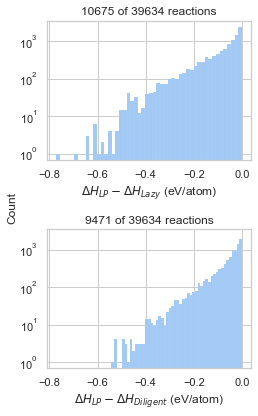

In [235]:
def set_small_to_zeros(a: list[float], eps=1e-5):
    a = np.array(a)
    a[np.abs(a) < eps] = 0
    return a

def is_qualitative_diff(sol1, sol2):
    sol_lazy = set_small_to_zeros(sol1).astype(bool)
    sol_exact = set_small_to_zeros(sol2).astype(bool)
    for i in range(len(sol_lazy)):
        if sol_lazy[i] != sol_exact[i]:
            return True
    return False

def plot_greedy_vs_exact_hist(records):
    nonzero_diff_lazy = []
    nonzero_diff_diligent = []
    lazy_wrong = []
    lazy_wrong_quali = []
    diligent_wrong = []
    diligent_wrong_quali = []
    for i, record in enumerate(records):
        dh_lazy = record["dh_old"]
        dh_diligent = record["dh_diligent"]
        dh_exact = record["dh_exact"]
        diff_lazy = dh_exact - dh_lazy
        diff_diligent = dh_exact - dh_diligent
        sol_lazy = record["sol_old"]
        sol_diligent = record["sol_diligent"]
        sol_exact = record["sol_exact"]
        # exact should never be worse
        assert diff_diligent < 1e-7
        assert diff_lazy < 1e-7

        if is_qualitative_diff(sol_exact, sol_diligent):
            diligent_wrong_quali.append(i)

        if is_qualitative_diff(sol_exact, sol_lazy):
            lazy_wrong_quali.append(i)

        if abs(diff_diligent) > 1e-7:
            diligent_wrong.append(i)
            nonzero_diff_diligent.append(diff_diligent)

        if abs(diff_lazy) > 1e-7:
            lazy_wrong.append(i)
            nonzero_diff_lazy.append(diff_lazy)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4, 6))
    ylim = None
    xlim = None
    for name, data, ax, quali, quanti in zip(
        ["Lazy", "Diligent",],
        [nonzero_diff_lazy, nonzero_diff_diligent],
        [ax1, ax2],
        [lazy_wrong_quali, diligent_wrong_quali],
        [lazy_wrong, diligent_wrong]
    ):
        ax.hist(data, linewidth=0.05, bins=50)
        ax.set_yscale("log")
        ax.set_title("{} of {} reactions".format(len(data), len(records)))
        ax.set_xlabel(r"$\Delta H_{{LP}} - \Delta H_{{{}}}$ (eV/atom)".format(name))
        if xlim is None:
            xlim = ax.get_xlim()
        else:
            this_xlim = ax.get_xlim()
            xlim = [min([this_xlim[0], xlim[0]]), max([this_xlim[1], xlim[1]])]
        if ylim is None:
            ylim = ax.get_ylim()
        else:
            this_ylim = ax.get_ylim()
            ylim = [min([this_ylim[0], ylim[0]]), max([this_ylim[1], ylim[1]])]
        print("{}: max diff = {:.4f} eV/atom, mean diff = {:.4f}".format(name, min(data), np.mean(data)))
        print("qualitative diff = {}".format(len(quali)), "same as quantitative diff?: {}".format(set(quali) == set(quanti)))
    for ax in [ax1, ax2]:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    fig.supylabel("Count", fontsize=12, x=0.1)
    fig.tight_layout()
    print("Do lazy and diligent always both get things wrong?", set(lazy_wrong) == set(diligent_wrong))
    both_wrong = set(lazy_wrong).intersection(set(diligent_wrong))
    print("# of cases where both laze and diligent are wrong:", len(both_wrong))
    return fig, lazy_wrong, diligent_wrong

fig, lazy_wrong, diligent_wrong = plot_greedy_vs_exact_hist(mp_oxidation_records)
figname = "greedy_vs_lp_mpox"
fig.savefig("data/float/{}.eps".format(figname), bbox_inches="tight")
fig.savefig("data/float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})

In [1]:
# let's look at those with high Delta H difference
def formula_dict_to_string(d:dict):
    return " ".join(["{}{:.3f}".format(k, v) for k, v in d.items()])

def format_solution(oxides: list[Compound], solution:np.ndarray) -> str:
    s = ""
    final = 0
    for i, oxi in zip(solution, oxides):
        if is_close_to_zero(i):
            continue
        s += "\t{:.4f} -- {} -- {:.2f} -- {}\n".format(i, formula_dict_to_string(oxi.normalized_formula), oxi.formation_energy_per_atom, oxi.mpid)
        final += oxi.formation_energy_per_atom * i
    s += "\tformation enthalpy sum of products: {:.6f}".format(final)
    return s

def print_high_dh_diff(records, greedy_field_suffix="old", greed_name="LAZY", k=5, reverse=False, diffcutoff=1e-4):
    high_h_diff = [records[i] for i in lazy_wrong]
    high_h_diff = [r for r in high_h_diff if abs(r["dh_exact"] - r["dh_{}".format(greedy_field_suffix)]) > diffcutoff]
    high_h_diff = sorted(high_h_diff, key=lambda x:x["dh_exact"] - x["dh_{}".format(greedy_field_suffix)], reverse=reverse)
    for r in high_h_diff[:k]:
        original = r["original"]
        oxides = r["oxides"]
        sol_greedy = r["sol_{}".format(greedy_field_suffix)]
        sol_exact = r["sol_exact"]
        print("="*6)
        print("Reactant: " + formula_dict_to_string(original.normalized_formula) + "\t" + original.mpid)
        print("EXACT solution:")
        print(format_solution(oxides, sol_exact))
        print("{} GREEDY solution:".format(greed_name))
        print(format_solution(oxides, sol_greedy))

print_high_dh_diff(mp_oxidation_records, "old", "LAZY", 5, True)

NameError: name 'Compound' is not defined

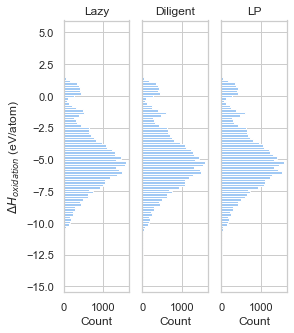

In [225]:
# reproduce Fig. 6 (a)
def plot_greedy_vs_exact_dist(records):
    lazy_oxidation_dhs = []
    diligent_oxidation_dhs = []
    exact_oxidation_dhs = []
    for r in records:
        lazy_oxidation_dhs.append(r["dh_old"])
        diligent_oxidation_dhs.append(r["dh_diligent"])
        exact_oxidation_dhs.append(r["dh_exact"])

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(4, 5), sharey=True, sharex=True)

    ylabel_already_set = False
    for ax, data, title in zip(axes, [lazy_oxidation_dhs, diligent_oxidation_dhs, exact_oxidation_dhs], ["Lazy", "Diligent", "LP"]):
        ax.hist(data, bins=100, orientation="horizontal")
        ax.set_title(title)
        if not ylabel_already_set:
            ax.set_ylabel(r"$\Delta H_{oxidation}$ (eV/atom)")
            ylabel_already_set = True
        ax.set_xlabel("Count")
        # ax.set_xscale("log")
    return fig

fig = plot_greedy_vs_exact_dist(records=mp_oxidation_records)

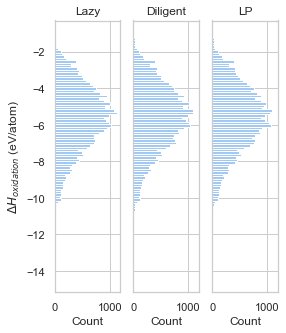

In [226]:
# Fig. 6 (c)
halogens = {"F", "Cl", "Br"}  # no I
mp_oxidation_records_no_halogens = [r for r in mp_oxidation_records if not set(r["original"].elements).intersection(halogens)]
fig = plot_greedy_vs_exact_dist(mp_oxidation_records_no_halogens)

In [6]:
# cases where ehull inconsistent
ehull_inconsistent = []
for mpid in mpid_to_recal_ehull:
    if not is_close_to_zero(mpid_to_recal_ehull[mpid] - mpid_to_ehull[mpid], eps=1e-1):
        ehull_inconsistent.append(mpid)
print(len(ehull_inconsistent), len(mpid_to_recal_ehull))


2136 126320


100%|██████████| 126320/126320 [00:00<00:00, 1010463.63it/s]


fig5_data: dh_old mean: -0.008033 mean negative: -0.023412 mae: 0.008033 mae negative: 0.023412


100%|██████████| 126320/126320 [00:00<00:00, 1154535.63it/s]


fig5_data: dh_diligent mean: -0.006292 mean negative: -0.019207 mae: 0.006292 mae negative: 0.019207


100%|██████████| 126320/126320 [00:00<00:00, 912620.35it/s]
D:\project\whygreedy\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\project\whygreedy\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fig5_data: dh_exact mean: 0.000000 mean negative: nan mae: 0.000000 mae negative: nan


100%|██████████| 126320/126320 [00:00<00:00, 898231.39it/s]


fig5_data: pmg mean: 0.000000 mean negative: nan mae: 0.000000 mae negative: nan


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


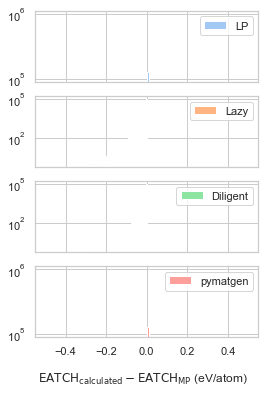

In [10]:

def mae(x):
    d = np.array(x)
    return np.mean(np.abs(d))

def mae_negative(x):
    d = np.array(x)
    d = d[d<-1e-7]
    return mae(d)

def mean_negative(x):
    d = np.array(x)
    mean = np.mean(d[d<-1e-7])
    return mean

def generate_fig5_data(records, dh_field, supress_small_values=1e-7, recal_ehull=False):
    """
    [from page 2549 of the original article]
    > changing all positive reaction enthalpies to a value
    > of 0 meV/atom to match the “stable” EATCH values and
    > making positive all remaining negative reaction enthalpies.
    """
    fig5_data = []
    for record in tqdm(records):
        if dh_field != "pmg":
            dh = record[dh_field]
            if dh > 0:
                dh = 0
            else:
                dh = - dh
        else:
            dh = mpid_to_recal_ehull[record["original"]]

        if recal_ehull:
            ehull = mpid_to_recal_ehull[record["original"]]
        else:
            ehull = mpid_to_ehull[record["original"]]

        fig5_delta = dh - ehull
        if supress_small_values and abs(fig5_delta) < supress_small_values:
            fig5_delta = 0.0
        fig5_data.append(fig5_delta)
    fig5_data = np.array(fig5_data)
    print("fig5_data:", dh_field, "mean: {:.6f}".format(np.mean(fig5_data)), "mean negative: {:.6f}".format(mean_negative(fig5_data)), "mae: {:.6f}".format(mae(fig5_data)), "mae negative: {:.6f}".format(mae_negative(fig5_data)))
    return fig5_data

fig5_data_old = generate_fig5_data(mp_decomposition_records, dh_field="dh_old", recal_ehull=True)
fig5_data_diligent = generate_fig5_data(mp_decomposition_records, dh_field="dh_diligent", recal_ehull=True)
fig5_data_exact = generate_fig5_data(mp_decomposition_records, dh_field="dh_exact", recal_ehull=True)
fig5_data_pmg = generate_fig5_data(mp_decomposition_records, dh_field="pmg", recal_ehull=True)

# zoom in fig5

fig5_df = pd.DataFrame(np.array([fig5_data_exact, fig5_data_old, fig5_data_diligent, fig5_data_pmg]).T, columns=["LP", "Lazy", "Diligent", "pymatgen"])
fig, axes = plt.subplots(len(fig5_df.columns), 1, figsize=(4, 6), sharex=True)
fig.supxlabel(r"$\mathrm{EATCH}_{\mathrm{calculated}} -\mathrm{EATCH}_{\mathrm{MP}}$ (eV/atom)", fontsize=12)
#
colors = sns.color_palette("pastel")
for i, col in enumerate(fig5_df.columns):
    data = fig5_df[col]
    axes[i].hist(data, bins=100, facecolor=colors[i], label=col)
    axes[i].legend()
    # if i != len(fig5_df.columns) - 1:
    #     axes[i].set_xticks
    # axes[i].hist(data, bins=47, range=[-0.05, 0.01])
#     # sns.histplot(ax=axes[i], data=fig5_df, x=col, bins=100)
#     axes[i].set_xlim([-0.05, 0.01]
    axes[i].set_yscale('log')

figname = "eatch_decomp"
fig.savefig("data/float/{}.eps".format(figname), bbox_inches="tight")
fig.savefig("data/float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})


In [8]:
print(max(fig5_data_exact))



10.358134063569445


In [15]:
# why the inconsistency between pymatgen and MP?

for i, delta in enumerate(fig5_data_exact):
    if delta > 1:
        target_competing_pair = mp_decomposition_pairs[i]
        target_record = mp_decomposition_records[i]["dh_exact"]
        break
target_c, target_cps = target_competing_pair

pymatgen_hull = mpid_to_recal_ehull[target_c.mpid]
_, lp_hull = find_lp(target_cps, target_c)
print("decomposition of :{}".format(target_c.mpid))
print("pymatgen simplex gives: {:.6f}".format(pymatgen_hull))
print("LP gives: {:.6f}".format(-lp_hull))  # negative decomposition enthalpy
print("However, value from MP for {} is: {:.6f}".format(target_c.mpid, mpid_to_ehull[target_c.mpid]))

# what if we exclude a competing phase from the list?
print("="*6)
exclude_index = 19
print("exclude compound {} with formation energy: {:.6f}".format(target_cps[exclude_index].mpid, target_cps[exclude_index].formation_energy_per_atom))
updated_target_cps = [cp for cp in target_cps]
updated_target_cps.pop(exclude_index)
pymatgen_hull = pymatgen_ehull([target_c, updated_target_cps])["pmg_ehull"]
_, lp_hull = find_lp(updated_target_cps, target_c)
print("pymatgen simplex gives: {:.6f}".format(pymatgen_hull))
print("LP gives: {:.6f}".format(-lp_hull))  # negative decomposition enthalpy

decomposition of :mp-1318211
pymatgen simplex gives: 10.402309
LP gives: 10.402309
However, value from MP for mp-1318211 is: 0.044175
exclude compound mp-778012 with formation energy: -13.568631
pymatgen simplex gives: 0.044175
LP gives: 0.044175
